# Fairness tradeoff example

- $TP$: true positives
- $TN$: true negatives
- $FP$: false positives
- $FN$: false negatives

- $PPV$: positive predictive value, a.k.a. precision

$$ PPV = TP / (TP + FN) $$

- $FPR$: false positive rate, i.e. the rate at which controls are incorrectly deemed high risk

$$ FPR = FP / (FP + TN)  $$

- $FNR$: false negative rate, i.e. the rate at which cases are incorrectly deemed low risk

$$ FNR = FN / (FN + TP)  $$

- $p$: prevalence of the outcome, i.e. proportion of cases among cases and controls

## relation between $PPV$, $FPR$, $FNR$, and $p$

$$ FPR = \frac{p}{1-p} \frac{1-PPV}{PPV} (1-FNR) $$

# create simulated dataset

Creates an illustrative example dataset in which there are two groups, a and b, who experience the outcome at different rates (prevalences of 20% and 50%, respectively). These patients share an identically distributed risk factor, x.

In [1]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# two groups
groups = ['a','b']
# sample size
N = {
    'a':50000,
    'b':50000
}

# prevalence of the outcome in the groups
prevalence = {
    'a':0.2, 
    'b':0.5
} 
total_prevalence = (prevalence['a'] * N['a'] + prevalence['b'] * N['b']) / (N['a'] + N['b']) 
print('total_prevalence:',total_prevalence)
# log_odds = np.log(total_prevalence / (1-total_prevalence))
log_odds = np.log(prevalence['a'] / (1-prevalence['a']))
print('log odds:',log_odds)
# risk factor distribution parameters
x_mean = {
    'a':0, 
    'b':0
} 
x_sigma = {
    'a':1, 
    'b':1
} 

# noise
t_noise, x_noise, y_noise = 0,0,0
t_noise=0.4
# x_noise = 0.0 
y_noise = .4


def calc_FPR(p, PPV, FNR):
    """Returns the FPR given prevalence (p), positive predictive value (PPV), and false negative rate (FNR)."""
    return p/(1-p) * (1-PPV)/PPV * (1-FNR)
    
   
def outcome(x, p):
    """define the outcome such that the prevalence is p."""
    rms = np.sqrt(np.mean(np.sum(x**2)))
    print('rms*t_noise:',rms*t_noise)
    print('std(x)',x.std())
    def get_t(x, prev, t_std):
        """set a threshold on x to match prevalence, plus noise."""
        t = np.random.normal(
                np.quantile(x, 1-p),
                t_std
        )
        return t
    count = 0
    y = np.ones(len(x))
    t_std = t_noise
    while np.abs(y.mean()-p) > 0.01 and count < 10:
        ts = np.asarray([get_t(x,p, t_std) for xi in x]) 
        y =  np.array([xi > ti for xi,ti in zip(x,ts)])
        print('ts:',ts)
        print('prevalence error:',y.mean()-p)
        count += 1
        t_std = t_std*.9

    print('sampled prevalence before noise:', y.mean())
    
    y_tmp = np.ones(len(x)).astype(bool)
    y_noise_pos = y_noise*(1-p)
    y_noise_neg = y_noise*p
    count = 0
    while np.abs(y_tmp.mean()-p) > 0.01 and count < 10:
        y_tmp = np.copy(y).astype(bool)
        # add label noise
        print('pos noise:',y_noise_pos)
        print('neg noise:',y_noise_neg)
        y_tmp[y_tmp] = np.array([True if np.random.rand() > y_noise_pos else False for yi in y_tmp[y_tmp]])
        y_tmp[~y_tmp] = np.array([False if np.random.rand() > y_noise_neg else True for yi in y_tmp[~y_tmp]])
        print('sampled prevalence after noise:', y_tmp.mean())
        
        print('prevalence error:',y_tmp.mean()-p)
        if y.mean()-p > 0.01:
            y_noise_pos = 0.9*y_noise_pos
        elif y.mean()-p < 0.01:
            y_noise_neg = 0.9*y_noise_neg
            
        count += 1
    y = y_tmp
        
    print('actual prevalence:',p,'final sampled prevalence:', y.mean())
    return y

frames = []
for g in groups:
    xg = np.random.normal(x_mean[g], x_sigma[g], size=N[g])
    # xg = np.random.binomial(1, .35, size=N[g])
    y = outcome(xg, prevalence[g])
    frames.append(pd.DataFrame(dict(
        group=g,
        y=y,
        x=xg
    )))
df_sim = pd.concat(frames)

print(df_sim.groupby('group')['y'].mean())

def get_x(df, include_group):
    if include_group: 
        X = df[['x','group']].copy()
        X['group'] = X['group'].apply(lambda x: 0 if x == 'a' else 1)
        return X
        # X = df[['x','group']].values
        # X[:,1] = [0 if x == 'a' else 1 for x in X[:,1]]
    else:
        return df[['x']]
    #     X = df['x'].values.reshape(-1,1) 
        
    # sigma = np.sqrt(np.mean(np.sum(X[:,0]**2)))
    # X[:,0] = X[:,0]+np.random.normal(0, x_noise*sigma)
    # # return StandardScaler().fit_transform(X)
    # return X

total_prevalence: 0.35
log odds: -1.3862943611198906
rms*t_noise: 89.4570259071115
std(x) 1.0001598664026605
ts: [0.88331732 0.81839157 1.22475116 ... 1.00770889 0.75959819 0.89206003]
prevalence error: 0.017359999999999987
ts: [1.21504891 0.42810714 1.05119225 ... 0.7798698  0.89860648 1.12046447]
prevalence error: 0.013819999999999999
ts: [1.28787532 0.80895696 0.4931147  ... 0.89588133 1.12127294 0.49899172]
prevalence error: 0.010520000000000002
ts: [1.29946761 0.81655788 0.45634228 ... 0.88437205 0.42748182 0.23791623]
prevalence error: 0.008859999999999979
sampled prevalence before noise: 0.20886
pos noise: 0.32000000000000006
neg noise: 0.08000000000000002
sampled prevalence after noise: 0.20988
prevalence error: 0.00988
actual prevalence: 0.2 final sampled prevalence: 0.20988
rms*t_noise: 89.57710533675385
std(x) 1.0015024011596745
ts: [ 0.04779889  1.37042996 -0.4288775  ...  0.36494421  0.02729965
 -0.73208218]
prevalence error: -0.0007400000000000184
sampled prevalence befor

# utility functions

Functions for computing equalized odds, getting roc curves, and the like. 

In [4]:
def equalized_odds(fprs, tprs, roc_thresholds):
    """
    Set example operating points to match 1) equalized odds and 2) equal PPV
    """
    assert all(fprs['a'] == fprs['b'])

    # get the difference in TPR between groups
    diff_tpr = np.abs(tprs['a'] - tprs['b'])
    # filter out corners
    mask = (tprs['a']>.9) | (tprs['b']>.9) | (tprs['a']<.1) | (tprs['b']<.1)
    diff_tpr[mask] = 10
    diff_tpr = np.array([round(dt, 3) for dt in diff_tpr])
    # index that minimizes the difference
    idx_tpr = np.argmin(diff_tpr)
    fpr_match = fprs['a'][idx_tpr]
    tpr_match = (tprs['a'][idx_tpr] + tprs['b'][idx_tpr])/2
    
    t_a = roc_thresholds['a'][idx_tpr]
    t_b = roc_thresholds['b'][idx_tpr]
        
        
    diff_tprs = tprs['a'] - tprs['b']
    diff_fprs = fprs['a'] - fprs['b']
    # diff_youden = youden['a'] - youden['b']
    # idx_youden = np.argmin(diff_youden)
    # print('at',idx_youden)
    # [print(f'fprs {g}: ',fprs[g][idx_youden]) for g in groups]
    # [print(f'tprs {g}: ',tprs[g][idx_youden]) for g in groups]

    # print('at',idx_tpr)
    # [print(f'fprs {g}: {fprs[g][idx_tpr]:.2f}') for g in groups]
    # [print(f'tprs {g}: {tprs[g][idx_tpr]:.2f}') for g in groups]
    return fpr_match, tpr_match, t_a, t_b

def get_curves(y_true, y_pred):
    """
    get metrics of performance from models
    """
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred)
    ppv, recall, pr_thresholds = precision_recall_curve(y_true, y_pred)
    auroc = roc_auc_score(y_true,y_pred)
    auprc = average_precision_score(y_true,y_pred)
    
    # interprolate the data for the false positive rates so that they can be aggregated
    n_steps = 100
    mean_fpr = np.linspace(0, 1, n_steps)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_roc_thresholds = np.interp(mean_fpr, fpr, roc_thresholds) 
    # interp_thresholds = roc_thresholds
    #same for recall 
    mean_recall = np.linspace(1,0, n_steps)
    # have to reverse for interp, which assumes increasing values
    interp_ppv = np.interp(mean_recall[::-1], recall[::-1], ppv[::-1])[::-1]
    pr_thresholds = np.append(pr_thresholds, 1.0)
    interp_pr_thresholds = np.interp(mean_recall[::-1], recall[::-1], pr_thresholds[::-1])[::-1]
    
    return dict(
        mean_fpr=mean_fpr, 
        interp_tpr=interp_tpr, 
        mean_recall=mean_recall, 
        interp_ppv=interp_ppv, 
        interp_roc_thresholds=interp_roc_thresholds,
        interp_pr_thresholds=interp_pr_thresholds,
        auroc=auroc, 
        auprc=auprc
    )


# Generate Models and Visualize performance

This code generates risk prediction models from the input data

estimator coef: [-0.72736739] [[1.1232784]]
estimator coef: [-1.72630044] [[1.2966841 1.7662225]]
EO threshold group a: 0.22854912167424044
EO threshold group b: 0.513641102990697
threshold at equal PPV for group a 0.4119462827183685
threshold at equal PPV for group b 0.3915207614959538


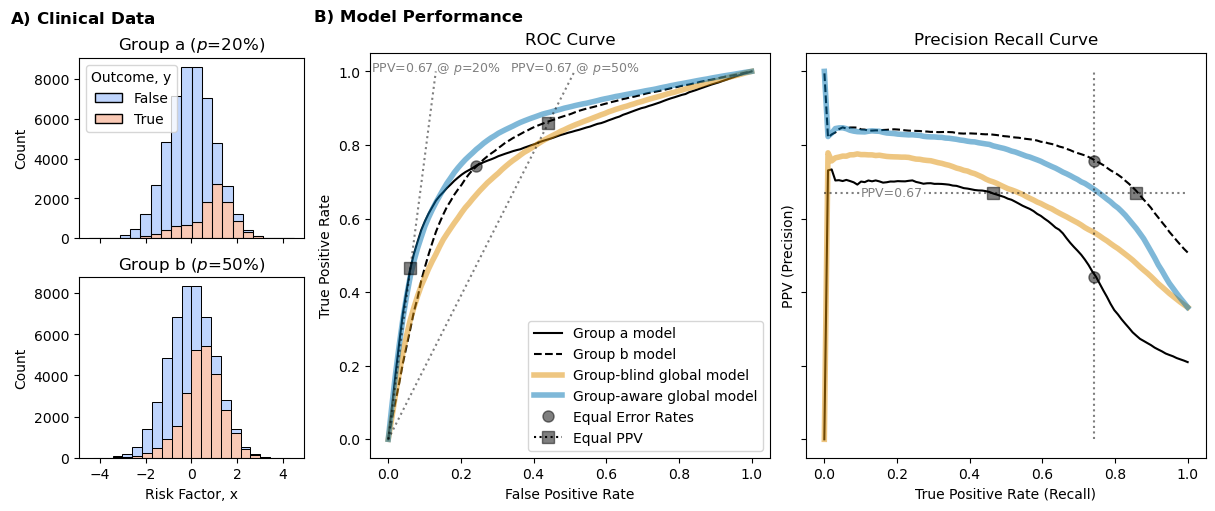

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

real_prevalence={
    'a': df_sim.loc[df_sim.group=='a','y'].mean().round(2),
    'b': df_sim.loc[df_sim.group=='b','y'].mean().round(2),
}
palette= sns.color_palette("colorblind") #, 2)
results = {}    
marker = {
    # 'a':'x',
    # 'b':'+',
    'a':None,
    'b':None,
    ('a','a'):None,
    ('b','b'):None,
    ('a','b'):'^',
    ('b','a'):'v',
    'Group-blind global model':None,
    'Group-aware global model':None,
}
linestyle = {
    'a':'-',
    'b':'--',
    ('a','b'):'-',
    ('b','a'):'-',
    ('a','a'):'-',
    ('b','b'):'-',
    'Group-blind global model':'-',
    'Group-aware global model':'-',
}
color = {
    'ppv':'k',
    'eo':'k',
    # 'a':palette[0],
    # 'b':palette[1],
    'a':'k',
    'b':'k',
    'Group-aware global model':palette[0],
    'Group-blind global model':palette[1],
}
markersize=8
textbox=dict(
    facecolor='w', 
    alpha=1, 
    edgecolor='w',
    boxstyle='Square, pad=0.0'
    
)
textsize=9
markerfacecolor=(0, 0, 0, 0.5)
# for include_group in [False, True]:
########################################
# create figure
########################################
fig = plt.figure(layout='constrained', figsize=(12, 5))
subfigs = fig.subfigures(1, 2, wspace=0.01, width_ratios=[1,3])
laxes = subfigs[0].subplots(2,1, sharex=True)

for g, lax in zip(groups,laxes):
    # sns.kdeplot(
    sns.histplot(
        ax=lax,
        data=df_sim.loc[df_sim.group==g],
        x='x',
        hue='y',
        multiple='stack',
        # kde=True,
        fill=True,
        bins=20,
        # discrete=True,
        # aspect=2,
        # height=2,
        palette='coolwarm',
        legend=g=='a',
    )
    if g=='a':
        sns.move_legend(lax,'upper left', title='Outcome, y')
    lax.set_title(f'Group {g} ($p$={prevalence[g]*100:g}%)')
ax = subfigs[1].subplots(1,2, sharey=True)
lax.set_xlabel('Risk Factor, x')
    
include_group= True
est = LogisticRegression(penalty=None)
X = get_x(df_sim, include_group)
est.fit(X, df_sim['y'])
    
################################################################################
# within-group metrics
################################################################################

for g, dfg in df_sim.groupby('group'):
    
    Xg = get_x(dfg, include_group)
    est.fit(Xg,dfg['y'])
    rg = est.predict_proba(Xg)[:,1]
    yg = dfg['y'].values
                    
    idx = g                
    results[idx] = get_curves(yg, rg)
    
    ax[0].plot(
        results[idx]['mean_fpr'], 
        results[idx]['interp_tpr'], 
        # label = f'Group {g} model (AUC={results[idx]["auroc"]:.2f})',
        label = f'Group {g} model',
        marker=marker[idx],
        linestyle=linestyle[idx],
        markevery=10,
        color=color[idx]
    )
    ax[1].plot(
        results[idx]['mean_recall'], 
        results[idx]['interp_ppv'], 
        label = f'Group {g} model',
        marker=marker[idx],
        linestyle=linestyle[idx],
        markevery=10,
        color=color[idx]
    )

################################################################################
# Group-aware versus group-blind model
################################################################################

for include_group in [False, True]:
    est = LogisticRegression(penalty=None)
    
    X = get_x(df_sim, include_group)
    est.fit(X, df_sim['y'])
    
    if hasattr(est, 'intercept_'):
        print('estimator coef:',est.intercept_,est.coef_)
    
    r = est.predict_proba(X)[:,1]
    y = df_sim['y'].values

    label = 'Group-aware global model' if include_group else 'Group-blind global model'
    idx = label
    results[label] = get_curves(y, r)

    linewidth=4
    alpha=0.5
    ax[0].plot(
        results[idx]['mean_fpr'], 
        results[idx]['interp_tpr'], 
        label=label,
        marker=marker[idx],
        linestyle=linestyle[idx],
        markevery=10,
        color=color[idx],
        linewidth=linewidth,
        alpha=alpha
    )
    ax[1].plot(
        results[idx]['mean_recall'], 
        results[idx]['interp_ppv'], 
        # label = label+f' (AUPRC={results[idx]["auprc"]:.2f})',
        label = label,
        marker=marker[idx],
        linestyle=linestyle[idx],
        markevery=10,
        color=color[idx],
        linewidth=linewidth,
        alpha=alpha
    )

################################################################################
# find thresholds where equalized odds is satisfied
################################################################################
    
fprs = {k:results[k]['mean_fpr'] for k in ['a','b']}
tprs = {k:results[k]['interp_tpr'] for k in ['a','b']}
roc_thresholds = {k:results[k]['interp_roc_thresholds'] for k in ['a','b']}
fpr_match, tpr_match, t_a, t_b = equalized_odds(fprs, tprs, roc_thresholds)
print('EO threshold group a:',t_a)
print('EO threshold group b:',t_b)
threshold_at_eo_match = {'a':t_a,'b':t_b}
ax[0].plot(
    fpr_match,tpr_match,
    'o', 
    color=color['eo'], 
    label='Equal Error Rates', 
    # label=f'Equal Error Rates (FPR={fpr_match:.2f}, TPR={tpr_match:.2f})',
    # alpha=0.5,
    markersize=markersize,
    markerfacecolor=markerfacecolor,
)

########################################    
# plot the equalized odds spot on PR curve
########################################    
ppv_at_tpr_match = {}
for g in groups:
    ppv_at_tpr_match[g] = results[g]['interp_ppv'][np.argmin(np.abs(results[g]['mean_recall']-tpr_match))]
    
ax[1].plot(
    [tpr_match,tpr_match],
    [0, 1],
    ':', 
    color=color['eo'], 
    # label='Equal Error Rates',
    label=None,
    alpha=0.5,
)
# MARK ERROR RATE BALANCE
for g in groups:
    ax[1].plot(
        tpr_match,
        ppv_at_tpr_match[g],
        '-.o', 
        color=color['eo'], 
        markerfacecolor=markerfacecolor,
        label=f'Equal Error Rates' if g=='a' else None,
        # alpha=0.5,
        markersize=markersize,
    )

################################################################################    
# mark equal PPV
################################################################################    
# target_ppv = np.max(results['a']['interp_ppv'][results['a']['mean_recall']>.1])
target_ppv = 0.67
recall_at_ppv_match = {}
threshold_at_ppv_match = {}
pr_thresholds = {k:results[k]['interp_pr_thresholds'] for k in ['a','b']}

for g in groups:
    idx = np.argmin(np.abs(results[g]['interp_ppv']-target_ppv))
    recall_at_ppv_match[g] = results[g]['mean_recall'][idx]

    threshold_at_ppv_match[g] = pr_thresholds[g][idx] 
    ax[1].plot(
        recall_at_ppv_match[g], 
        target_ppv, 
        ':s',
        color=color['ppv'],
        markerfacecolor=markerfacecolor,
        # label=f'Equal PPV ({target_ppv:.1f})' if g=='a' else None,
        label=f'Equal PPV' if g=='a' else None,
        # alpha=0.5,
        markersize=markersize
    )
    print(f'threshold at equal PPV for group {g}', threshold_at_ppv_match[g])
    
ax[1].plot(
    [0, 1], 
    [target_ppv,target_ppv], 
    ':',
    color=color['ppv'],
    # label='Equal PPV',
    alpha=0.5,
)
ax[1].text(
    # recall_at_ppv_match['b']+0.03, 
    0.1,
    target_ppv, 
    f'PPV={target_ppv:.2f}',
    color=color['ppv'],
    # label='Equal PPV',
    alpha=0.5,
    bbox=textbox,
    verticalalignment='center',
    fontsize=textsize,
)

# get line of equal PPV for each group
fprs_at_ppv = {}
for g in groups:
    fprs_at_ppv[g] = np.empty(len(results[g]['interp_tpr']))
                              
    for i,tpr in enumerate(results[g]['interp_tpr']):
        fprs_at_ppv[g][i] = calc_FPR(real_prevalence[g], target_ppv, 1-tpr)

    ax[0].plot(
        fprs_at_ppv[g],
        results[g]['interp_tpr'],
        ':',
        # label=f'PPV={target_ppv:.2f}, $p$={prevalence[g]:.2f}',
        label=None,
        alpha=0.5,
        color=color['ppv']
    )
    pos = round(len(fprs_at_ppv[g])/2)
    fap =  fprs_at_ppv[g][-1]
    # if g=='a': 
    #     fap+=0.05
    # else:
    #     fap-=0.1
    ax[0].text(
        fap,
        results[g]['interp_tpr'][-1],
        f'PPV={target_ppv:.2f} @ $p$={prevalence[g]*100:g}%',
        alpha=0.5,
        fontsize=textsize,
        rotation=0,
        horizontalalignment='center', # if g=='a' else 'left',
        # horizontalalignment='center',
        # rotation_mode='anchor',
        # transform_rotates_text=True
    )
    # import pdb
    # pdb.set_trace()
    fpr_at_ppv_match = calc_FPR(real_prevalence[g], target_ppv, 1-recall_at_ppv_match[g])
    ax[0].plot(
        fpr_at_ppv_match, 
        recall_at_ppv_match[g],
        ':s',
        markerfacecolor=markerfacecolor,
        # label=f'PPV={target_ppv:.1f}' if g =='a' else None,
        label='Equal PPV' if g =='a' else None,
        # alpha=0.5,
        markersize=markersize,
        color=color['ppv']
    )
    
################################################################################
# figure cleanup
################################################################################
# ax[0].set_xlim(0,1)
ax[0].legend()
# ax[1].legend()
ax[0].set_ylabel('True Positive Rate')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_title('ROC Curve')
# ax[0].grid(True)
# ax[1].grid(True)
# ax[0].plot([0, 1],[0, 1], '-k',alpha=.25)
subfigs[0].suptitle(
    r'$\bf{A)}$ Clinical Data',
    x=0,
    ha='left', 
    fontweight='bold'
)
ax[1].set_xlabel('True Positive Rate (Recall)')
ax[1].set_ylabel('PPV (Precision)')
ax[1].set_title('Precision Recall Curve')
# ax[1].set_yticklabels([])
# ax[1].set_yticks([])
model1 = r'$\sigma(y) = \beta_0 + \beta_1 x $' # + \epsilon$'
model2 = r'$\sigma(y) = \beta_0 + \beta_1 x + \beta_2 g $' # + \epsilon$'
subfigs[1].suptitle(
    'B) Model Performance',
    # r'$\bf{B)}$ $\bf{Model}$'+f'\n\tgroup-blind:\t{model1}\n\tgroup-aware:  {model2}',
    x=0,
    ha='left', 
    fontweight='bold'
)

# subfigs[1].set_linewidth(1.0)
# ax[0].grid(True)
# ax[1].grid(True)
for t in ['pdf','png']:
    plt.savefig(f'fairness-example.{t}', dpi=400, bbox_inches='tight')

# Table of subgroup metrics

Generate  a table of metrics for various approaches to equalizing performance of the model(s) on groups. 

models:
- stratified
- group-blind, threshold chosen by max F1
- group-aware, threshold chosen by max F1
- group-aware, equalized odds
- group-aware, equal PPV




In [6]:
thresh_strategy = 'f1'

def get_threshold(y_true, y_pred, how='f1'):
    if how == 'f1':
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        metric = (2 * precision * recall) / (precision + recall)
    elif how == 'J':
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        # get the best threshold
        metric = tpr - fpr
        
    print(how,len(metric),np.nanmax(metric))
    i = np.nanargmax(metric)
    t = thresholds[i]
    print('tmax:',t)
    return t

def get_class_metrics(y_true, y_pred, t=0.5, y_pred_thresholded=None):
    """
    get metrics of performance from models
    """
    print('y_pred',y_pred)
    if type(t) is str:
        t = get_threshold(y_true, y_pred, how=t)
    if y_pred_thresholded is not None: 
        yp = y_pred_thresholded
    else:
        yp = (y_pred > t)
    TP = y_true[yp].sum()   
    TN = (~y_true)[~yp].sum()
    FN = y_true[~yp].sum()
    FP = (~y_true)[yp].sum()
    return dict(
        TPR = TP/(TP+FN),
        TNR = TN/(TN+FP),
        PPV = TP/(TP+FP),
        F1 = (2*TP)/(2*TP + FP + FN),
        Accuracy = (TP + TN)/(TP+TN+FP+FN),
        threshold=t,
        AUROC=roc_auc_score(y_true, y_pred),
        AUPRC=average_precision_score(y_true, y_pred),
    )
    

tbl_frames = []
estimators = {}
models = [
    'Group-blind',
    'Group-aware / Stratified',
    # 'Group-aware, single threshold',
    'Group-aware, Equal Error Rates',
    'Group-aware, Equal PPV'
]
for model in models:
    include_group = 'Group-aware' in model
    # if model != 'Stratified' not in model:
    X = get_x(df_sim, include_group)
    
    est = LogisticRegression(penalty=None)
    est.fit(X, df_sim['y'])
    
    y_pred_global = est.predict_proba(X)[:,1]
    y_true_global = df_sim['y']

    results = {}
    y_pred = {}
    y_true = {}
    model_thresholds = {}
    for g, dfg in df_sim.groupby('group'):
        
        Xg = get_x(dfg, include_group)
        # if 'Stratified' in model:
        #     est = LogisticRegression(penalty=None)
        #     est.fit(Xg,dfg['y'])
        y_pred[g] = est.predict_proba(Xg)[:,1]
        y_true[g] = dfg['y'].values
                        
        results[g] = get_curves(y_true[g], y_pred[g])

        if 'Equal' not in model:
            if 'Stratified' not in model:
                t = get_threshold(y_true_global, y_pred_global, thresh_strategy)
            else:
                t = thresh_strategy
            # metrics = get_class_metrics(y_true[g], y_pred[g], 0.5)
            metrics = get_class_metrics(y_true[g], y_pred[g], t=t)
            metrics['Model'] = model 
            metrics['Group'] = g
            model_thresholds[g] = metrics['threshold']
            tbl_frames.append(metrics)
        
    if 'Equal Error Rates' in model:
        fprs = {k:results[k]['mean_fpr'] for k in groups}
        tprs = {k:results[k]['interp_tpr'] for k in groups}
        thresholds = {k:results[k]['interp_roc_thresholds'] for k in groups}
        fpr_match, tpr_match, model_thresholds['a'], model_thresholds['b'] = equalized_odds(fprs, tprs, thresholds)
        for g in groups:
            metrics = get_class_metrics(y_true[g], y_pred[g], model_thresholds[g])
            metrics['Model'] = model 
            metrics['Group'] = g
            tbl_frames.append(metrics)
            
        
    elif 'Equal PPV' in model:
        thresholds = {k:results[k]['interp_pr_thresholds'] for k in groups}
        target_ppv = 0.67
        recall_at_ppv_match = {}
        for g in groups:
            idx = np.argmin(np.abs(results[g]['interp_ppv']-target_ppv))
            print('ppvs:',results[g]['interp_ppv'][idx-1],
                  results[g]['interp_ppv'][idx],
                  results[g]['interp_ppv'][idx+1])
            recall_at_ppv_match[g] = results[g]['mean_recall'][idx]
            model_thresholds[g] = thresholds[g][idx] 
            metrics = get_class_metrics(y_true[g], y_pred[g], model_thresholds[g])
            metrics['Model'] = model 
            metrics['Group'] = g
            # print(metrics)
            tbl_frames.append(metrics)

    ## get overall metrics
    y_pred_thresholded = np.array([yp > model_thresholds[g] for yp,g in zip(y_pred_global, df_sim['group'].values)])
    metrics = get_class_metrics(y_true_global, y_pred_global, 0.5, y_pred_thresholded)
    metrics['Model'] = model
    metrics['Group'] = 'both'
    del metrics['threshold'] 
    tbl_frames.append(metrics)

df_tbl = pd.DataFrame(tbl_frames).rename(columns={'threshold':'Decision Threshold'})

(
    df_tbl
    .groupby(['Model','Group'])
    # [['threshold','TPR','TNR','PPV']]
    [['AUROC','AUPRC','Decision Threshold','TPR','TNR','PPV','F1','Accuracy']]
    .mean()
    .unstack()
    .loc[ models ]
    .round(2)
    .style
    .highlight_max(axis=0, props='font-weight: bold;')
    .highlight_min(axis=0, props='font-style: italic;')
    .format(precision=2)
)

/var/folders/mw/j_dyskd90g71r91fkcf2v95h0000gn/T/ipykernel_14448/2060306315.py:6: RuntimeWarning: invalid value encountered in divide
  metric = (2 * precision * recall) / (precision + recall)
/var/folders/mw/j_dyskd90g71r91fkcf2v95h0000gn/T/ipykernel_14448/2060306315.py:6: RuntimeWarning: invalid value encountered in divide
  metric = (2 * precision * recall) / (precision + recall)
/var/folders/mw/j_dyskd90g71r91fkcf2v95h0000gn/T/ipykernel_14448/2060306315.py:6: RuntimeWarning: invalid value encountered in divide
  metric = (2 * precision * recall) / (precision + recall)


f1 100001 0.6400877922892323
tmax: 0.3444946541256485
y_pred [0.45774624 0.29262341 0.50004179 ... 0.45868618 0.39425609 0.72617671]
f1 100001 0.6400877922892323
tmax: 0.3444946541256485
y_pred [0.33409992 0.78508841 0.08314356 ... 0.63604366 0.41081041 0.29653855]
y_pred [0.45774624 0.29262341 0.50004179 ... 0.63604366 0.41081041 0.29653855]
y_pred [0.2530863  0.1294776  0.29184234 ... 0.2539134  0.20062385 0.55952331]
f1 50001 0.6059874888293119
tmax: 0.31068237033414686
y_pred [0.52083915 0.91491257 0.13108905 ... 0.82112482 0.61379445 0.47063044]
f1 50001 0.7614056946022206
tmax: 0.44220848410056174
y_pred [0.2530863  0.1294776  0.29184234 ... 0.82112482 0.61379445 0.47063044]
y_pred [0.2530863  0.1294776  0.29184234 ... 0.2539134  0.20062385 0.55952331]
y_pred [0.52083915 0.91491257 0.13108905 ... 0.82112482 0.61379445 0.47063044]
y_pred [0.2530863  0.1294776  0.29184234 ... 0.82112482 0.61379445 0.47063044]
ppvs: 0.6651535380507343 0.668128254316251 0.6722096956031567
y_pred [0.2

# Plot Decision Curves

Here we visualize the decision curves for the overall data and for group a and b. 

Decision curve analysis is a way to choose an operating point for a model based on its "net benefit" versus the alternatives of intervening on all patients or intervening on none. 

Like the results above, the prevalence differences between the groups make it difficult to find a satisfactory threshold to equalize net benefit for both groups.

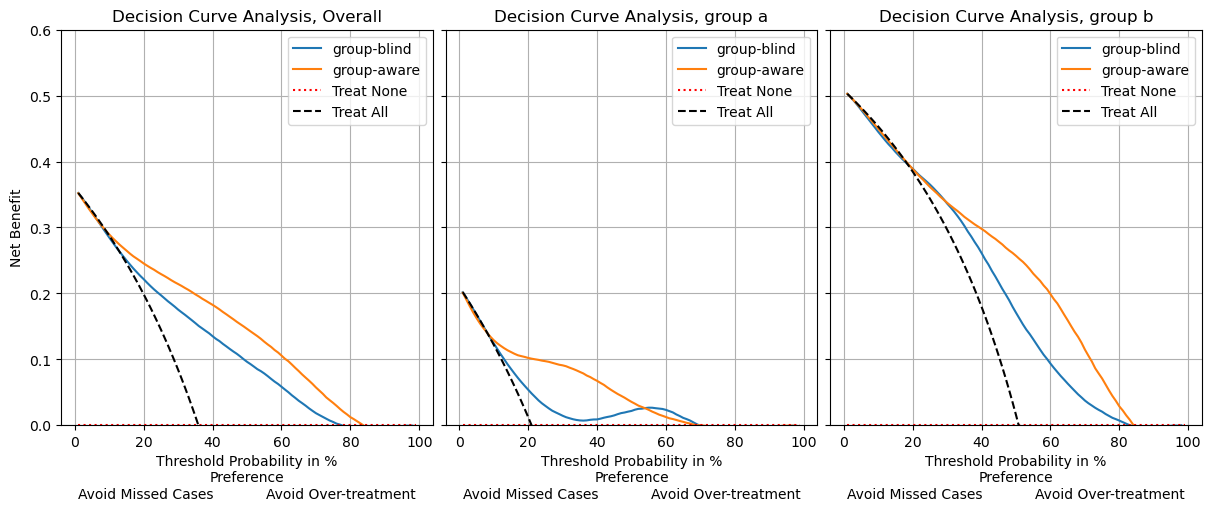

In [7]:
from sklearn.pipeline import Pipeline
from decision_curve_analysis import decision_curve_analysis, calculate_net_benefit_all

nbu = 0.6 

def plot_decision_curves(ax, clfs, labels, X_tests, y_test, p_min, p_max, epsilon, 
                         net_benefit_lower=0, net_benefit_upper=None):
    """
    Plotting the Net Benefit for a List of Classifiers (scikit-learn)
    :param clfs: List of binary classifiers
    :param labels: List of names (for including in the graph legend)
    :param X_test: Independent features (Test set)
    :param y_test: Target vector (Test set)
    :param p_min: Lower limit for the threshold probability
    :param p_max: Upper limit for the threshold probability
    :param epsilon: Increase in the threshold probability for calculating the net benefit
    :param net_benefit_lower: Lower limit for the Net Benefit (y axis)
    :param net_benefit_upper: Upper limit for the Net Benefit (y axis)
    :return: Decision Curve Analysis Plot
    """
    # Calculating True Positives and True Negatives (Test Set)
    tp_test = np.sum(y_test)
    tn_test = y_test.shape[0] - tp_test

    # Plotting each Classifier
    for i in range(0, len(clfs)):
        p, net_benefit = decision_curve_analysis(clfs[i], X_tests[i], y_test, p_min, p_max, epsilon)
        ax.plot(p, net_benefit, label=labels[i])

    # Plotting Prioritise None
    ax.hlines(y=0, xmin=p_min * 100, xmax=p_max * 100, label='Treat None', linestyles='dotted', color='red')

    # Plotting Prioritise All
    p_all, net_benefit_all = calculate_net_benefit_all(tp_test, tn_test, p_min, p_max, epsilon)
    ax.plot(p_all, net_benefit_all, label='Treat All', linestyle='dashed', color='black')

    # Figure Configuration
    xlabel = ('Threshold Probability in %'
              '\nPreference\n'
              'Avoid Missed Cases'
              '            Avoid Over-treatment'
             )
    ax.set_xlabel(xlabel)
    if net_benefit_lower is not None:
        ax.set_ylim(bottom=net_benefit_lower)
    if net_benefit_upper is not None:
        ax.set_ylim(top=net_benefit_upper)
    ax.legend()

    return ax

palette= sns.color_palette("colorblind") #, 2)
results = {}    
marker = {
    # 'a':'x',
    # 'b':'+',
    'a':None,
    'b':None,
    ('a','b'):'^',
    ('b','a'):'v',
    'All, group-blind':None,
    'All, group-aware':None,
}
linestyle = {
    'a':'-',
    'b':'--',
    ('a','b'):'-',
    ('b','a'):'-',
    'All, group-blind':'-',
    'All, group-aware':'-',
}
color = {
    'ppv':'k',
    'eo':'k',
    # 'a':palette[0],
    # 'b':palette[1],
    'a':'k',
    'b':'k',
    'All, group-aware':palette[0],
    'All, group-blind':palette[1],
}
markersize=8
textbox=dict(
    facecolor='w', 
    alpha=1, 
    edgecolor='w',
    boxstyle='Square, pad=0.0'
    
)
textsize=9
########################################
# create figure
########################################
fig = plt.figure(layout='constrained', figsize=(12, 5))

axes = fig.subplots(1,3, sharex=True, sharey=True)
    
# initial model for group-wise stats
est = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression(penalty=None))
]) 

################################################################################
# Group-aware versus group-blind model
################################################################################
ests = []
X_tests = []
labels = []

for include_group in [False, True]:
    est = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', LogisticRegression(penalty=None))
    ]) 
    # est = LogisticRegression(penalty=None)
    # est = GradientBoostingClassifier()
    
    X = get_x(df_sim, include_group)
    est.fit(X, df_sim['y'])
    
    ests.append(est)
    X_tests.append(X)
    labels.append('group-aware' if include_group else 'group-blind')

ax = plot_decision_curves(
    axes[0],
    ests, 
    labels,
    X_tests, 
    df_sim['y'].values, 
    0.01,
    0.99,
    0.01,
    net_benefit_upper=nbu
)
ax.set_title(f'Decision Curve Analysis, Overall')
ax.grid(True)
ax.set_ylabel('Net Benefit')
################################################################################
# within-group metrics
################################################################################

for i,(g, dfg) in enumerate(df_sim.groupby('group')):
    X_tests = [] 
    for include_group in [False, True]:
        Xg = get_x(dfg, include_group)
        X_tests.append(Xg)

    ax = plot_decision_curves(
        axes[i+1],
        ests, 
        labels,
        X_tests, 
        dfg['y'].values, 
        0.01,
        0.99,
        0.01,
        net_benefit_upper=nbu
    )
    ax.set_title(f'Decision Curve Analysis, group {g}')
    ax.grid(True)
    # # plot line at equal EO
    # ax.plot(
    #     [100*threshold_at_eo_match[g], 100*threshold_at_eo_match[g]],
    #     [0, nbu],
    #     ':r',
    #     label='Equal Error Rates Threshold'
    # )

    # # plot line at equal PPV
    # ax.plot(
    #     [100*threshold_at_ppv_match[g], 100*threshold_at_ppv_match[g]],
    #     [0, nbu],
    #     ':k',
    #     label='Equal PPV Threshold'
    # )
    ax.legend()